In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

In [3]:
# name of the notebook
name_notebook = "sweep_12h_er_Xqm"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="Try to find the best measurement and number of layers for the quantum block using Angle Encoding (repeating embedding) and embedding.",
#     repetitions=list(range(1, 3)),
#     n_layers_quantum_block=[2,10,20],
#     embedding_n_layers=[0,1,2,3],
#     embedding_dim=[1,5],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-2", day='0918', initial_path=initial_path)



 --- SWEEP POINT 5/48: (1, 2, 2, 1) ---
 --- time reamining: 195:20:38.88 

Epoch [0/2], Loss epoch: 0.5173, Loss validation: 0.5180
	 Validation string, 	 i: 1075; 	 prediction: -0.4695, 	 target: -0.4533, 	 loss: 0.0003
	 Validation string, 	 i: 2341; 	 prediction: -0.3832, 	 target: -0.4554, 	 loss: 0.0052
	 Validation string, 	 i: 159; 	 prediction: -0.2834, 	 target: -0.3028, 	 loss: 0.0004
Epoch [1/2], Loss epoch: 0.0077, Loss validation: 0.0068, Time remaining: ~0.0h 17.0m 47s
	 Validation string, 	 i: 2888; 	 prediction: -0.1519, 	 target: -0.2383, 	 loss: 0.0075
	 Validation string, 	 i: 4044; 	 prediction: -0.3139, 	 target: -0.3313, 	 loss: 0.0003
	 Validation string, 	 i: 3145; 	 prediction: -0.1315, 	 target: -0.1238, 	 loss: 0.0001
Epoch [2/2], Loss epoch: 0.0070, Loss validation: 0.0072, Time remaining: ~0.0h 0.0m 0s


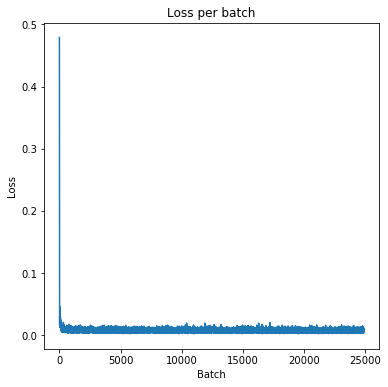

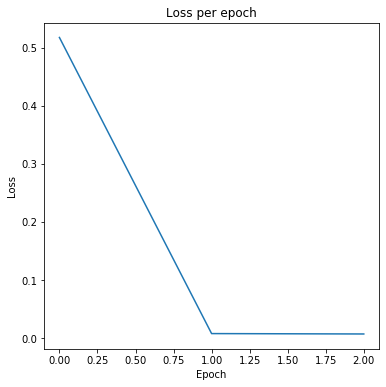

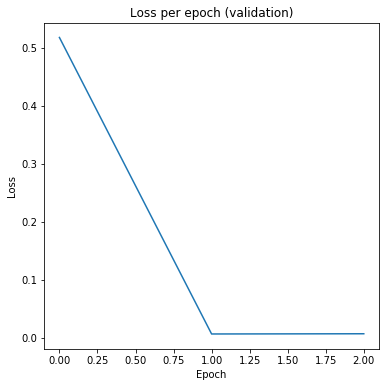

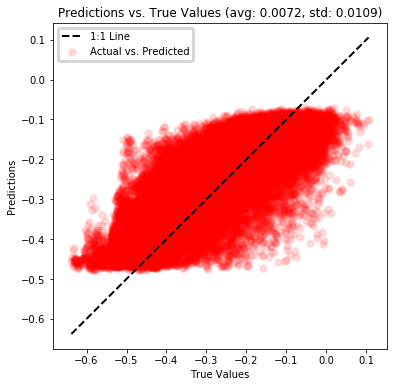

Mean loss: 0.0072281768381457145, std loss: 0.010894439837689764


 --- SWEEP POINT 6/48: (1, 2, 2, 5) ---
 --- time reamining: 161:41:05.27 

Epoch [0/2], Loss epoch: 0.3609, Loss validation: 0.3615
	 Validation string, 	 i: 1570; 	 prediction: -0.1779, 	 target: -0.1231, 	 loss: 0.0030
	 Validation string, 	 i: 1692; 	 prediction: -0.2847, 	 target: -0.2593, 	 loss: 0.0006
	 Validation string, 	 i: 724; 	 prediction: -0.4144, 	 target: -0.4504, 	 loss: 0.0013
Epoch [1/2], Loss epoch: 0.0065, Loss validation: 0.0058, Time remaining: ~0.0h 17.0m 45s
	 Validation string, 	 i: 4186; 	 prediction: -0.1366, 	 target: -0.0524, 	 loss: 0.0071
	 Validation string, 	 i: 230; 	 prediction: -0.1465, 	 target: -0.1421, 	 loss: 0.0000
	 Validation string, 	 i: 2348; 	 prediction: -0.3204, 	 target: -0.3320, 	 loss: 0.0001
Epoch [2/2], Loss epoch: 0.0058, Loss validation: 0.0056, Time remaining: ~0.0h 0.0m 0s


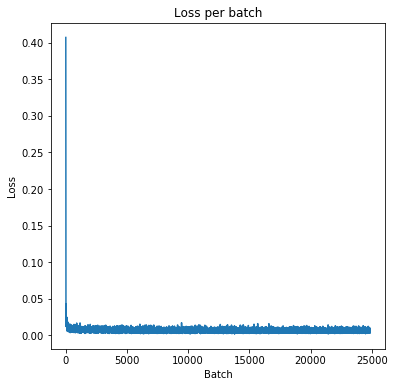

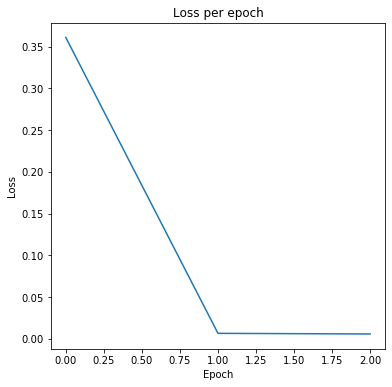

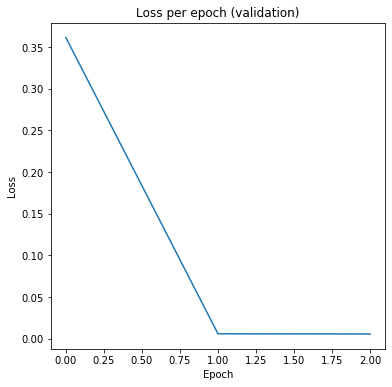

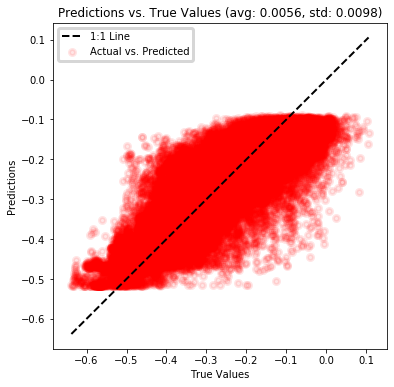

Mean loss: 0.005586157306305974, std loss: 0.00977741328368887


 --- SWEEP POINT 7/48: (1, 2, 3, 1) ---
 --- time reamining: 138:51:07.30 

Epoch [0/2], Loss epoch: 0.3539, Loss validation: 0.3546


In [27]:
for sweep_point in sweep.points_left:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 6
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding, 
        embedding_ansatz = q.parts.Ansatz_11,
        block_ansatz = q.parts.Ansatz_11,
        final_ansatz = q.parts.Ansatz_11, # TODO CHECK IF THIS IS THE BEST OPTION
        measurement = q.parts.Measurement('Z', 'all'),
        embedding_n_layers = sweep_point['embedding_n_layers'],
        different_inputs_per_layer = False,
        block_n_layers = sweep_point['n_layers_quantum_block'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=sweep_point['embedding_dim'])
            self.fc2 = m.Reshape()
            self.fc3 = m.nn.Sequential(*[m.nn.Linear(12*sweep_point['embedding_dim'], 6), m.nn.Sigmoid(), m.nn.Linear(6, 6)])
            self.fc4 = quantum_layer()            
            self.fc5 = m.nn.Sequential(*[m.nn.Linear(6, 6), m.nn.Sigmoid(), m.nn.Linear(6, 1)])

        def forward(self, x):
            for i in range(1,6):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids and {} qubits using Angle Encoding (repeating embedding) and classical Embedding'.format(n_qubits),    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    